In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import seaborn as sns

## Load Data

In [2]:
df1 = pd.read_csv('/Users/nzhang/OneDrive/Data/lending_club/FinTech_data/loan_2014.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df1.shape

(235631, 95)

In [4]:
df1.nunique().sort_index()

accnowdelinq                    5
accopenpast24mths              37
addrstate                      49
allutil                         0
annualinc                   18248
annualincjoint                  0
applicationtype                 1
avgcurbal                   47604
bcopentobuy                 38469
bcutil                       1255
chargeoffwithin12mths           8
collections12mthsexmed          9
delinq2yrs                     22
delinqamnt                    546
desc                        14843
dti                          3995
dtijoint                        0
earliestcrline                638
emplength                      11
emptitle                    75352
ficorangehigh                  38
ficorangelow                   38
fundedamnt                   1309
grade                           7
homeownership                   4
id                         235631
ilutil                          0
initialliststatus               2
inqfi                           0
inqlast12m    

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235631 entries, 0 to 235630
Data columns (total 95 columns):
taxliens                      235629 non-null float64
totalbalexmort                235629 non-null float64
maxbalbc                      0 non-null float64
totcurbal                     235629 non-null float64
desc                          15279 non-null object
revolbal                      235629 non-null float64
mthssincelastdelinq           119748 non-null float64
mortacc                       235629 non-null float64
delinq2yrs                    235629 non-null float64
zipcode                       235629 non-null object
mosinoldrevtlop               235629 non-null float64
mthssincelastmajorderog       66478 non-null float64
openil12m                     0 non-null float64
numbctl                       235629 non-null float64
term                          235629 non-null object
pubrec                        235629 non-null float64
bcutil                        233018 non

## Select Data

In [6]:
all_null_feature =['inqlast12m',
 'verificationstatusjoint',
 'maxbalbc',
 'annualincjoint',
 'memberid',
 'openil6m',
 'openacc6m',
 'totalbalil',
 'inqfi',
 'mthssincercntil',
 'openrv24m',
 'openrv12m',
 'dtijoint',
 'openil12m',
 'openil24m',
 'allutil',
 'totalcutl',
 'ilutil']

In [7]:
ob_feature=['initialliststatus',
 'grade',
 'subgrade',
 'earliestcrline',
 'applicationtype',
 'intrate',
 'desc',
 'term',
 'homeownership',
 'addrstate',
 'revolutil',
 'id',
 'zipcode',
 'verificationstatus',
 'emptitle',
 'emplength',
 'purpose',
 'issued',
 'loanstatus']

In [8]:
num_feature=['bcopentobuy', 'numactvbctl', 'mthssincelastrecord', 'totcurbal', 'totalbalexmort', 'mosinrcnttl', 'mortacc', 'mthssincelastdelinq', 'numactvrevtl', 'tothicredlim', 'ficorangehigh', 'bcutil', 'numbctl', 'totalrevhilim', 'totcollamt', 'numtl120dpd2m', 'ficorangelow', 'totalacc', 'mthssincerecentbcdlq', 'installment', 'numrevaccts', 'pubrec', 'accopenpast24mths', 'numoprevtl', 'avgcurbal', 'dti', 'delinq2yrs', 'fundedamnt', 'mosinoldilacct', 'annualinc', 'numtl30dpd', 'loanamnt', 'numsats', 'mthssincerecentrevoldelinq', 'mthssincerecentbc', 'revolbal', 'inqlast6mths', 'totalilhighcreditlimit', 'collections12mthsexmed', 'chargeoffwithin12mths', 'numtl90gdpd24m', 'delinqamnt', 'mosinoldrevtlop', 'taxliens', 'numbcsats', 'totalbclimit', 'numacctsever120pd', 'accnowdelinq', 'pcttlnvrdlq', 'mthssincerecentinq', 'numiltl', 'mosinrcntrevtlop', 'openacc', 'numrevtlbalgt0', 'mthssincelastmajorderog', 'numtloppast12m', 'percentbcgt75', 'pubrecbankruptcies']

In [9]:
select_feature=ob_feature+num_feature
len(select_feature)

77

In [10]:
# remove applicationtype since it only has one value as 'individual'
ob_feature.remove('applicationtype')

In [11]:
# remove fundedamnt since it always equals to 1 for issued loans and varied during different time of a current loan
num_feature.remove('fundedamnt')

In [12]:
# remove 'id','issued' and 'loanstatus' from ob_feature, since they are index, train/test flag and target
ob_feature.remove('id')
ob_feature.remove('loanstatus')
ob_feature.remove('issued')

In [13]:
# remove 'desc' from ob_feature and select_feature
ob_feature.remove('desc')

In [14]:
select_feature=ob_feature+num_feature
len(select_feature)

71

In [15]:
# selected features left and delete the last two rows
df=df1[select_feature+['id','loanstatus','issued']][:-2]

In [16]:
df.shape

(235629, 74)

## only use term=36 months and loanstatus = fully paid and charged off

In [17]:
df1.loanstatus.value_counts()

Fully Paid            134710
Current                62046
Charged Off            34765
Late (31-120 days)      2154
In Grace Period         1504
Late (16-30 days)        444
Default                    6
Name: loanstatus, dtype: int64

In [18]:
df = df.query("loanstatus == 'Fully Paid' or loanstatus == 'Charged Off' ")

In [19]:
df = df.query("term ==' 36 months'")

In [20]:
df.shape

(129487, 74)

In [21]:
ob_feature.remove('term')

## Label Target

In [22]:
df['loanstatus'] = df.loanstatus.map({"Charged Off": 1, "Fully Paid": 0})

In [23]:
print(df.loanstatus.value_counts())
print(df.loanstatus.value_counts(normalize=True))

0    108778
1     20709
Name: loanstatus, dtype: int64
0    0.840069
1    0.159931
Name: loanstatus, dtype: float64


## Out of time testing set and in-time training set: Oct~Dec as test)

In [24]:
issued=list(df['issued'].unique())
issued

['Dec-2014',
 'Nov-2014',
 'Oct-2014',
 'Sep-2014',
 'Aug-2014',
 'Jul-2014',
 'Jun-2014',
 'May-2014',
 'Apr-2014',
 'Mar-2014',
 'Feb-2014',
 'Jan-2014']

In [25]:
df['train_flg'] = df.issued.apply(lambda x: 0 if x in issued[:3] else 1)
df.train_flg.value_counts()

1    98997
0    30490
Name: train_flg, dtype: int64

## Feature Engineering & Cleaning

#### Datetime to numeric feature

In [26]:
df.earliestcrline.unique()[:5]

array(['Sep-1989', 'Nov-1992', 'Aug-2002', 'Oct-1998', 'Jan-2001'], dtype=object)

In [27]:
# convert to number of months to Dec 2014

In [28]:
cl_month=df.earliestcrline.apply(lambda x: x.split('-')[0])
cl_year=df.earliestcrline.apply(lambda x: int(x.split('-')[1]))

In [29]:
cl_month.unique()

array(['Sep', 'Nov', 'Aug', 'Oct', 'Jan', 'May', 'Jul', 'Dec', 'Jun',
       'Mar', 'Apr', 'Feb'], dtype=object)

In [30]:
cl_year.unique()

array([1989, 1992, 2002, 1998, 2001, 1999, 2009, 2003, 1993, 1995, 1996,
       2007, 2004, 1997, 2008, 2011, 2006, 2010, 1988, 1994, 2000, 1987,
       2005, 1986, 1973, 1982, 1991, 1984, 1976, 1974, 1981, 1990, 1978,
       1979, 1985, 1983, 1971, 1967, 1972, 1968, 1980, 1977, 1965, 1966,
       1975, 1969, 1963, 1970, 1964, 1958, 1962, 1959, 1955, 1960, 1961,
       1954, 1957, 1949, 1950, 1948, 1953, 1956])

In [31]:
dic_month= {'Jan':11,'Feb':10,'Mar':9,'Apr':8, 'May':7, 'Jun':6, 'Jul':5, 'Aug':4, 'Sep':3, 'Oct':2, 'Nov':1, 'Dec':0}

In [32]:
df['earliestcrline_month']=df.earliestcrline.apply(lambda x: (2014-int(x.split('-')[1]))*12+dic_month[x.split('-')[0]])

In [33]:
df.earliestcrline_month[:5]

0    303
2    265
3    148
6    194
7    167
Name: earliestcrline_month, dtype: int64

In [34]:
num_feature.append('earliestcrline_month')
ob_feature.remove('earliestcrline')

In [35]:
print(len(ob_feature), len(num_feature))

12 58


### emplength to numeric feature

In [36]:
print(df['emplength'].isnull().sum())
df['emplength'].unique()

7321


array(['8 years', '10+ years', '< 1 year', '2 years', '7 years', '9 years',
       nan, '4 years', '3 years', '1 year', '5 years', '6 years'], dtype=object)

In [37]:
df['emplength'].replace('n/a', np.nan, inplace=True)
df['emplength'].replace('< 1 year', '0', inplace=True)
df['emplength'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df.emplength.fillna(value=-999,inplace=True)
df['emplength'] = df['emplength'].astype(int)

In [38]:
df.emplength.value_counts()

 10     40456
 2      11807
 0      10538
 3      10523
 1       8502
 4       7572
 5       7395
-999     7321
 7       7211
 6       6704
 8       6457
 9       5001
Name: emplength, dtype: int64

In [39]:
num_feature.append('emplength')
ob_feature.remove('emplength')
print(len(num_feature), len(ob_feature))

59 11


## % to numeric feature: intrate, revolutil

In [40]:
intrate=df.intrate.apply(lambda x: float(x.replace('%','')))

In [41]:
df.intrate=intrate
df.intrate[:2]

0     6.99
2    13.66
Name: intrate, dtype: float64

In [42]:
df.revolutil[:3]

0    31.6%
2    59.4%
3    91.9%
Name: revolutil, dtype: object

In [43]:
revolutil=df.revolutil.apply(lambda x: str(x).replace('%','')).astype(float)

In [44]:
df.revolutil=revolutil
df.revolutil[:2]

0    31.6
2    59.4
Name: revolutil, dtype: float64

In [45]:
ob_feature.remove('intrate')
num_feature.append('intrate')
ob_feature.remove('revolutil')
num_feature.append('revolutil')

In [46]:
print(len(ob_feature), len(num_feature))

9 61


#### Ordinal feature encoding : grade, subgrade

In [47]:
Dic_grade = {"A": 1, 
            "B": 2, 
            "C": 3, 
            "D": 4, 
            "E": 5,
            "F": 6, 
            "G": 7}

In [48]:
df.grade = df.grade.map(Dic_grade)

In [49]:
df.subgrade = df.subgrade.apply(lambda x: (Dic_grade[x[0]] - 1) * 5 + int(x[1]))

In [50]:
ob_feature.remove('grade')
num_feature.append('grade')
ob_feature.remove('subgrade')
num_feature.append('subgrade')

In [51]:
print(len(ob_feature), len(num_feature))

7 63


### High cardinality feature encoding

###### Zip Code - frequency encoding 

In [52]:
print(df.zipcode.nunique(), df.zipcode.unique()[:5])

850 ['937xx' '077xx' '850xx' '982xx' '144xx']


In [53]:
# convert zipcode to int
df.zipcode = df.zipcode.apply(lambda x: int(x[0:3]))

In [54]:
df.zipcode[:5]

0    937
2     77
3    850
6    982
7    144
Name: zipcode, dtype: int64

In [55]:
zipcode_freq = df.groupby("zipcode").size().reset_index()

In [56]:
zipcode_freq[:5]

,zipcode,0
0,8,1
1,10,180
2,11,46
3,12,47
4,13,32


In [57]:
zipcode_freq.columns = ["zipcode", "zipcode_freq"]

In [58]:
df = pd.merge(df, zipcode_freq, how = "left", on = "zipcode")

In [59]:
df.zipcode_freq[:5]

0    203
1    288
2    602
3    381
4    163
Name: zipcode_freq, dtype: int64

In [60]:
ob_feature.remove('zipcode')
num_feature.append('zipcode')
num_feature.append('zipcode_freq')
print(len(ob_feature), len(num_feature))

6 65


### emptitle-frequency encoding (can do some NLP for later stage)

In [61]:
emptitle_freq = df.groupby("emptitle").size().reset_index()
emptitle_freq.columns = ["emptitle", "emptitle_freq"]
df = pd.merge(df, emptitle_freq, how = "left", on = "emptitle")

In [62]:
ob_feature.remove('emptitle')
num_feature.append('emptitle_freq')
print(len(ob_feature), len(num_feature))

5 66


###### Addr_state - frequency encoding

In [63]:
addrstate_freq = df.groupby("addrstate").size().reset_index()
addrstate_freq.columns = ["addrstate", "addrstate_freq"]
df = pd.merge(df, addrstate_freq, how = "left", on = "addrstate")


In [64]:
ob_feature.remove('addrstate')
num_feature.append('addrstate_freq')
print(len(ob_feature), len(num_feature))

4 67


#### One hot encoding

In [65]:
dummy_feature = ["homeownership", "verificationstatus", "purpose", "initialliststatus"]

In [66]:
df_dummy = pd.get_dummies(df[dummy_feature])

In [67]:
OHE_feature = list(df_dummy.columns.values)

In [68]:
len(OHE_feature)

22

In [69]:
df = pd.concat([df,df_dummy], axis=1)

In [70]:
df.shape

(129487, 101)

In [71]:
for feat in dummy_feature:    
    ob_feature.remove(feat)

In [72]:
len(ob_feature)

0

In [73]:
select_feature = num_feature + OHE_feature

In [74]:
len(select_feature)

89

##  XGBoost 

In [75]:
feat = select_feature
print(feat)

['bcopentobuy', 'numactvbctl', 'mthssincelastrecord', 'totcurbal', 'totalbalexmort', 'mosinrcnttl', 'mortacc', 'mthssincelastdelinq', 'numactvrevtl', 'tothicredlim', 'ficorangehigh', 'bcutil', 'numbctl', 'totalrevhilim', 'totcollamt', 'numtl120dpd2m', 'ficorangelow', 'totalacc', 'mthssincerecentbcdlq', 'installment', 'numrevaccts', 'pubrec', 'accopenpast24mths', 'numoprevtl', 'avgcurbal', 'dti', 'delinq2yrs', 'mosinoldilacct', 'annualinc', 'numtl30dpd', 'loanamnt', 'numsats', 'mthssincerecentrevoldelinq', 'mthssincerecentbc', 'revolbal', 'inqlast6mths', 'totalilhighcreditlimit', 'collections12mthsexmed', 'chargeoffwithin12mths', 'numtl90gdpd24m', 'delinqamnt', 'mosinoldrevtlop', 'taxliens', 'numbcsats', 'totalbclimit', 'numacctsever120pd', 'accnowdelinq', 'pcttlnvrdlq', 'mthssincerecentinq', 'numiltl', 'mosinrcntrevtlop', 'openacc', 'numrevtlbalgt0', 'mthssincelastmajorderog', 'numtloppast12m', 'percentbcgt75', 'pubrecbankruptcies', 'earliestcrline_month', 'emplength', 'intrate', 'revo

### Preliminary manually parameter tuning based on stratified train-test split

In [76]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
#Kfolds = StratifiedKFold(df_all['loan_status'], n_folds = 3, shuffle=True, random_state=2019)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [77]:
df_train = df.query("train_flg == 1")
df_test = df.query("train_flg == 0" )

In [78]:
print(df_train.shape, df_test.shape)

(98997, 101) (30490, 101)


In [79]:
df_train[feat].shape

(98997, 89)

In [80]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train[feat], df_train.loanstatus, 
                                                      test_size=0.3, random_state=2014, 
                                                      stratify = df_train.loanstatus )

In [81]:
X_test, y_test = df_test[feat], df_test.loanstatus

In [82]:
dtrain = xgb.DMatrix(X_train, y_train, missing = np.NAN)
dvalid = xgb.DMatrix(X_valid, y_valid, missing = np.NAN)
dtest = xgb.DMatrix(X_test, y_test, missing = np.NAN)

In [83]:
params = {"objective": "binary:logistic", 
          "booster" : "gbtree", 
          "eta": 0.05, 
          "max_depth": 6, 
          "subsample": 0.632, 
          "colsample_bytree": 0.7,
          #"colsample_bylevel": 0.6,
          "silent": 1, 
          "seed": 1234, 
          "eval_metric": "auc",
          #"gamma": 1, 
          "min_child_weight": 5} 

In [84]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round = 1500
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=50)

[0]	train-auc:0.67597	eval-auc:0.659669
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.686924	eval-auc:0.666362
[2]	train-auc:0.693525	eval-auc:0.670444
[3]	train-auc:0.698975	eval-auc:0.673936
[4]	train-auc:0.702113	eval-auc:0.675749
[5]	train-auc:0.704638	eval-auc:0.677218
[6]	train-auc:0.705755	eval-auc:0.678352
[7]	train-auc:0.707391	eval-auc:0.67889
[8]	train-auc:0.708948	eval-auc:0.678655
[9]	train-auc:0.710025	eval-auc:0.67982
[10]	train-auc:0.710295	eval-auc:0.680266
[11]	train-auc:0.711052	eval-auc:0.680832
[12]	train-auc:0.711872	eval-auc:0.681465
[13]	train-auc:0.712352	eval-auc:0.681887
[14]	train-auc:0.712728	eval-auc:0.682049
[15]	train-auc:0.713132	eval-auc:0.681869
[16]	train-auc:0.71403	eval-auc:0.682248
[17]	train-auc:0.714429	eval-auc:0.682248
[18]	train-auc:0.714945	eval-auc:0.682529
[19]	train-auc:0.715328	eval-auc:0.682456
[20]	train-auc:0.715673	eval-auc:

[191]	train-auc:0.799613	eval-auc:0.698164
[192]	train-auc:0.799912	eval-auc:0.698152
[193]	train-auc:0.800077	eval-auc:0.69821
[194]	train-auc:0.800238	eval-auc:0.698167
[195]	train-auc:0.800738	eval-auc:0.698217
[196]	train-auc:0.801048	eval-auc:0.698208
[197]	train-auc:0.801404	eval-auc:0.698172
[198]	train-auc:0.801842	eval-auc:0.698139
[199]	train-auc:0.802552	eval-auc:0.698089
[200]	train-auc:0.803268	eval-auc:0.69808
[201]	train-auc:0.803694	eval-auc:0.69796
[202]	train-auc:0.804128	eval-auc:0.697895
[203]	train-auc:0.804644	eval-auc:0.697829
[204]	train-auc:0.804796	eval-auc:0.697794
[205]	train-auc:0.805156	eval-auc:0.697779
[206]	train-auc:0.805645	eval-auc:0.697775
[207]	train-auc:0.805748	eval-auc:0.697816
[208]	train-auc:0.806227	eval-auc:0.697717
[209]	train-auc:0.806677	eval-auc:0.697837
[210]	train-auc:0.80749	eval-auc:0.697814
[211]	train-auc:0.807879	eval-auc:0.697735
[212]	train-auc:0.808373	eval-auc:0.697766
[213]	train-auc:0.808891	eval-auc:0.697862
[214]	train-auc

In [85]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pylab as pl
def draw_ROC(model, dtrain, dvalid, dtest, y_train, y_valid, y_test):
    probas_ = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    probas_1 = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    fpr, tpr, thresholds = roc_curve(y_valid, probas_)
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)
    roc_auc = auc(fpr, tpr)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    print("Area under the ROC curve - validation: %f" % roc_auc)
    print("Area under the ROC curve - train: %f" % roc_auc_1)
    print("Area under the ROC curve - test: %f" % roc_auc_2)
    # Plot ROC curve
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC curve - test(AUC = %0.2f)' % roc_auc, color='r')
    plt.plot(fpr_1, tpr_1, label='ROC curve - train (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - train (AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc="lower right")
    plt.show()


### ROC curve

Area under the ROC curve - validation: 0.698289
Area under the ROC curve - train: 0.796120
Area under the ROC curve - test: 0.708662


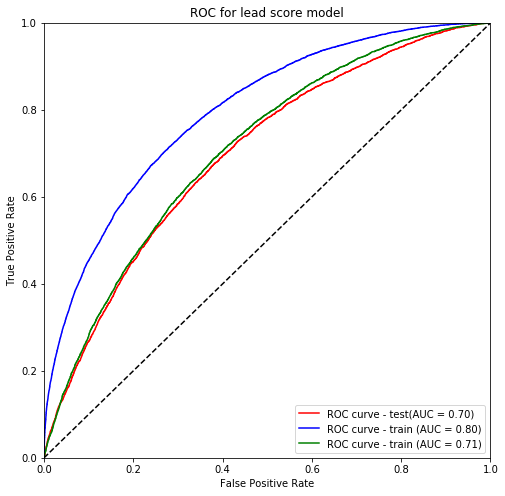

In [86]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

### Distribution of predicted values

In [87]:
y_pred = gbm.predict(dtest)

In [88]:
print(y_pred.max(), y_pred.min(), y_pred.mean())

0.776456 0.00777273 0.158766


### Feature importance

In [89]:
importance = gbm.get_fscore()

In [90]:
type(importance)

dict

In [91]:
df_importance = pd.DataFrame.from_dict(importance, orient='index').reset_index()
df_importance.columns=['feature', 'fscore']
#df_importance = pd.DataFrame(importance.items(), columns=['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [92]:
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
43,dti,0.044381
5,annualinc,0.038681
30,installment,0.036034
6,mosinoldilacct,0.033795
34,mosinoldrevtlop,0.031454
29,emptitle_freq,0.030334
25,zipcode_freq,0.028094
54,zipcode,0.027178
32,bcutil,0.026059
19,avgcurbal,0.025753


<Figure size 2304x2304 with 0 Axes>

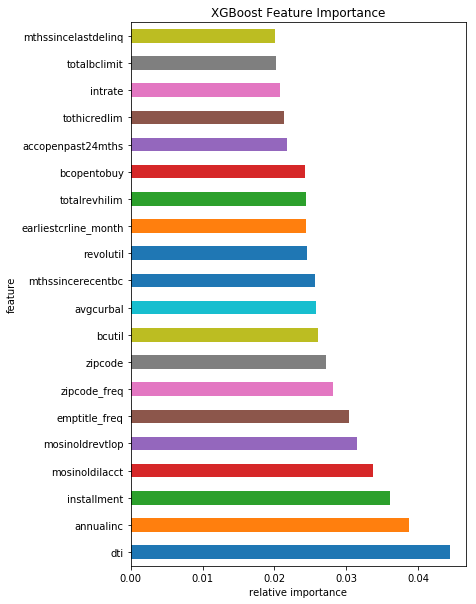

In [93]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance[:20].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [94]:
grade_importance = df_importance.query("feature=='grade'")
grade_importance

,feature,fscore
0,grade,0.003766


In [95]:
subgrade_importance = df_importance.query("feature=='subgrade'")
subgrade_importance

,feature,fscore
28,subgrade,0.017203


In [96]:
intrate_importance = df_importance.query("feature=='intrate'")
intrate_importance

,feature,fscore
1,intrate,0.020765


In [97]:
df_importance.query("feature=='loanamnt'")

,feature,fscore
8,loanamnt,0.01649


Text(0.5,0,'relative importance')

<Figure size 2304x2304 with 0 Axes>

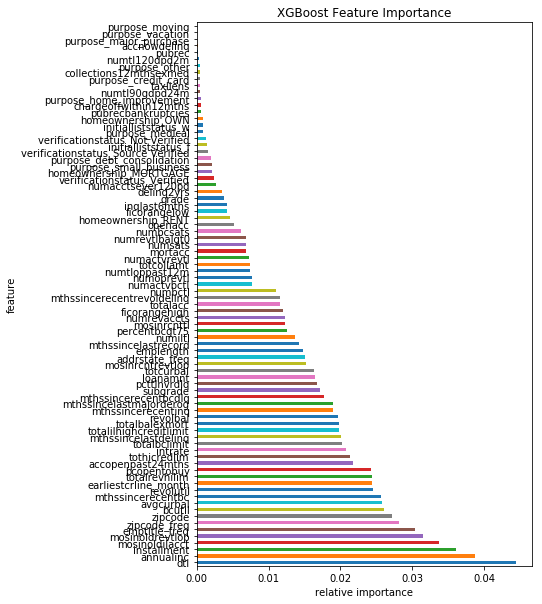

In [98]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

## Save model

In [99]:
import pickle

In [100]:
pickle.dump(gbm, open('model.pkl', "wb"))

In [101]:
from sklearn.externals import joblib
joblib.dump(gbm, 'pima.joblib.dat')

['pima.joblib.dat']

In [102]:
with open('model.pkl', 'wb') as outfile:
    pickle.dump(gbm, outfile)

In [106]:
pickle.dump(df[feat], open('feature.pkl', 'wb'))

In [107]:
with open('feature.pkl', 'wb') as outfile:
    pickle.dump(df[feat], outfile)